In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import time
import numpy as np
import datetime as d
import pandas as pd
import os.path as path
import pytz
import gsw

In [13]:
#  read in starmon temp loggers
dataDir = '/Users/edwardlrichards/Documents/data/KAM11/enviornment/WHOI_Temp_String/TemperatureString'
saveName = '/Users/edwardlrichards/cir_processing/Enviornment/processedData/seabird.pic'

seabirdName = ('1770', '4079')
seabirdFolder = 'SBE37'
seabirdDepths = np.array((10, 75))

utc = pytz.utc
start_time = d.datetime(2011, 6, 24, 6, 0, 0, tzinfo=utc)
end_time = d.datetime(2011, 7, 11, 19, 45, 0, tzinfo=utc)
dtimeI = pd.date_range(start_time, end_time, freq='15s')
parseStarmon = lambda x: d.datetime.strptime(x, '%d.%m.%y %H:%M:%S')

In [14]:
def parseSeabird(day, tod):
    if isinstance(day, float):
        return None
    datetime = d.datetime.strptime(day + tod, ' %d %b %Y %H:%M:%S')
    return datetime

In [15]:
# Load both seabird and starmon data
# First is seabird
tempData = None

for name, depth in zip(seabirdName, seabirdDepths):
    loadString = path.join(dataDir, seabirdFolder, name + '.asc')
    tempColumn = 'T_' + str(depth)
    pressColumn = 'P_' + str(depth)

    columnNames = [tempColumn, 'conductivity', 'pressure', 'day', 'tod']

    fileData = pd.read_csv(loadString, comment='*',
        parse_dates={'datetime': ['day','tod']},
        date_parser=parseSeabird, names=columnNames, index_col='datetime')
    
    fileData = fileData.ix[pd.notnull(fileData.index)]
    
#     # Seabird 1770 dropped at some point.
#     # This is clear in pressure record
#     if name == '1770':
#         cutoffTime = d.datetime.strptime('2011-07-03 11:54:30',\
#                             '%Y-%m-%d %H:%M:%S')
#         fileData.ix[cutoffTime:, depth] = np.nan

    # calculate salinity
    # convert from S/m to ms/cm
    fileData[pressColumn] = gsw.SP_from_C(10 * fileData['conductivity'],\
                                    fileData[tempColumn], fileData['pressure'])
    
#     del fileData['pressure']
#     del fileData['conductivity']
    
    if tempData is None:
        tempData = fileData
    else:
        tempData = pd.merge(tempData, fileData, left_index=True,
                            right_index=True, how='outer')

In [16]:
s10_drop = d.datetime.strptime('2011-07-03 11:54:30', '%Y-%m-%d %H:%M:%S')
s75_drop = d.datetime(2011, 6, 28, 7, 0, 0, tzinfo=utc)

In [17]:
tempData.columns

Index(['T_10', 'conductivity_x', 'pressure_x', 'P_10', 'T_75', 'conductivity_y', 'pressure_y', 'P_75'], dtype='object')

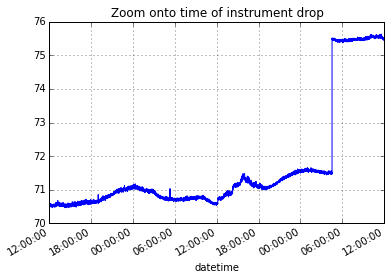

In [18]:
_ = tempData.ix[d.datetime(2011, 6, 26, 12, 0, 0, tzinfo=utc) :\
         d.datetime(2011, 6, 28, 12, 0, 0, tzinfo=utc), 'pressure_y'].interpolate().plot()
_ = plt.title('Zoom onto time of instrument drop')


In [19]:
compInterval = tempData.ix[d.datetime(2011, 6, 25, 0, 0, 0, tzinfo=utc) :\
         d.datetime(2011, 7, 11, 0, 0, 0, tzinfo=utc),:].interpolate()

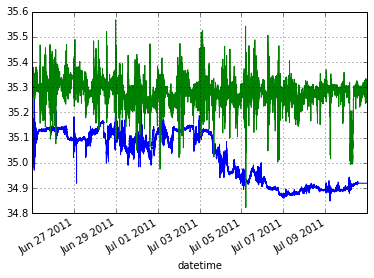

In [20]:
_ = compInterval['P_10'].interpolate().plot()
_ = compInterval['P_75'].interpolate().plot()

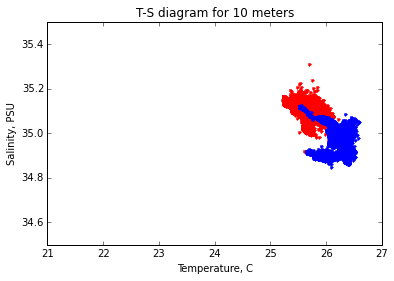

In [26]:
_ = plt.plot(compInterval.ix[:s10_drop,'T_10'].values,\
             compInterval.ix[:s10_drop,'P_10'].values,  'r.')
_ = plt.plot(compInterval.ix[s10_drop:,'T_10'].values,\
             compInterval.ix[s10_drop:,'P_10'].values,  'b.')
_ = plt.xlabel('Temperature, C')
_ = plt.ylabel('Salinity, PSU')
_ = plt.title('T-S diagram for 10 meters')
_ = plt.ylim(34.5, 35.5)
_ = plt.xlim(21,27)

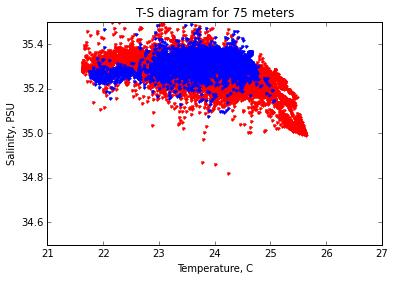

In [24]:
_ = plt.plot(compInterval.ix[s75_drop:,'T_75'].values,\
             compInterval.ix[s75_drop:,'P_75'].values, 'r.')
_ = plt.plot(compInterval.ix[:s75_drop,'T_75'].values,\
             compInterval.ix[:s75_drop,'P_75'].values, 'b.')
_ = plt.xlabel('Temperature, C')
_ = plt.ylabel('Salinity, PSU')
_ = plt.title('T-S diagram for 75 meters')
_ = plt.ylim(34.5, 35.5)
_ = plt.xlim(21,27)